In [ ]:
#default_exp Experiment

In [ ]:
#hide
#export
from typing import Dict, Any, List
import pandas as pd

import sys
sys.path.append("..")

from hephaestus.AbstractMethod import *
from hephaestus.IOUtils import *
from hephaestus.DatasetConstruction import *
from hephaestus.HephaestusModel import *
from hephaestus.TrainModels import *

# Experiment

> This is where the science happens. Which model is best? Is it actually beneficial to use EditOperations over raw token sequences when training an NMT model?

In [ ]:
#export
class HephaestusModelEvaluation:
    """
    Helper class to centralize computations when evaluating the effectiveness of a `HephaestusModel`.
    
    Required Arguments:
    
    - `model`: The `HephaestusModel` to evaluate
    - `testSourceMethods`: A list of AbstractMethods representing the buggy abstract methods in the testing set. These
      methods should not appear at all in the training or validation sets that were used to train the model.
    - `testTargetMethods`: A list of AbstractMethods representing the fixed abstract methods in the testing set. These
      methods should not appear at all in the training or validation sets that were used to train the model.
    
    Optional Arguments:
    
    - `isControl`: Set to `True` if the model represents the control, i.e. the model was trained purely with
      AbstractMethods and not with EditOperations. Defaults to `False`.
  
    Once created, the `HephaestusModelEvaluation` will contain the following attributes which can be freely accessed:
    
    - `outputMethods`: A list of AbstractMethods which were translated from the given buggy (source) AbstractMethods.
      These represent the model's predictions of what it thinks the fixed methods are. Some of these entries may be
      `None`, representing failed predictions.
    - `numPerfectPredictions`: The number of `outputMethods` whose tokens exactly match the actual fixed method according
      to the provided `testTargetMethods`.
    - `perfectPredictionRatio`: The ratio of perfect predictions to total predictions, in the range [0, 1].
    - `numFailedPredictions`: The number of `outputMethods` which were not able to be predicted due to ill-formed
      EditOperations or other factors. These are represented by `None` values in `outputMethods`.
    - `failedPredictionRatio`: The ratio of failed predictions to total predictions, in the range [0, 1].
    - `trainingStats`: A Pandas DataFrame representing model information while it was training, as in
      `HephaestusModel.getTrainingStats`.
    """

    def __init__(self, 
        model: HephaestusModel,
        testSourceMethods: List[AbstractMethod],
        testTargetMethods: List[AbstractMethod],
        isControl: bool = False
    ) -> None:

        # use the model to determine output methods
        self.outputMethods = model.translate(testSourceMethods, applyEditOperations = not isControl)

        # sanity check -- make sure that the lengths of all lists of methods are equal
        if not len(testSourceMethods) == len(testTargetMethods) == len(self.outputMethods):
            raise RuntimeError("HephaestusModelEvaluation: method number mismatch")
        
        # determine number of perfect predictions and failed predictions
        self.numPerfectPredictions = 0
        self.numFailedPredictions = 0
        for outputMethod, targetMethod in zip(self.outputMethods, testTargetMethods):
            if outputMethod == targetMethod:
                self.numPerfectPredictions += 1
            if outputMethod is None:
                self.numFailedPredictions += 1
        
        # obtain perfect prediction and failed prediction ratios
        self.perfectPredictionRatio = self.numPerfectPredictions / len(self.outputMethods)
        self.failedPredictionRatio = self.numFailedPredictions / len(self.outputMethods)
        
        # get the training statistics
        self.trainingStats = model.getTrainingStats()

## Helper functions

In [ ]:
#export
def plotTrainingAccuracies(
    evaluations: List[HephaestusModelEvaluation],
    lineLabels: List[str],
    title: str
) -> None:
    """
    Plots the training accuracies of the given `evaluations` as a line graph per training step. The line labels are the
    given `lineLabels`. The title is the given `title`.
    """
    
    # create dataframe
    data = {}
    for evaluation, label in zip(evaluations, lineLabels):
        data[label] = evaluation.trainingStats["trainAccuracy"].to_list()
    frame = pd.DataFrame(data, index = evaluations[0].trainingStats["step"].to_list())
    
    # create plot
    plot = frame.plot.line(
        title = title,
        xlabel = "Training Step",
        ylabel = "Training Accuracy %",
        grid = True
    )

In [ ]:
#export
def plotPerfectPredictionAccuracies(
    evaluations: List[HephaestusModelEvaluation],
    xLabels: List[str],
    title: str
) -> pd.DataFrame:
    """
    Plots the perfect prediction accuracies of the given `evaluations` as a bar graph. The x-axis labels are the
    given `xlabels`. The title of the graph is the given `title`. Returns the dataframe used to create the graph.
    """
    
    # create dataframe
    frame = pd.DataFrame({
        "model": xLabels,
        "accuracy": [100 * e.perfectPredictionRatio for e in evaluations]
    })

    # create plot
    plot = frame.plot.bar(
        x = "model",
        y = "accuracy",
        ylim = (0, max(frame["accuracy"]) + 2),
        xlabel = "Model",
        ylabel = "Perfect Prediction Accuracy %",
        title = title,
        rot = 0
    )

    # annotate the bars with their values
    for p in plot.patches:
        plot.annotate(
            "{:.1f}".format(p.get_height()),
            (p.get_x() + p.get_width() / 2, p.get_height() + 0.5),
            ha = "center",
            size = 10
        )
    
    return frame

In [ ]:
#export
def plotAllPerfectPredictionAccuracies(
    evaluations: Dict[str, HephaestusModelEvaluation],
    xLabels: List[str]
) -> None:
    """
    Plots the perfect predictions accuracies of all given `evaluations` as a nested bar graph. The x-axis labels are the
    given `xLabels`. Returns the dataframe used to create the graph.
    """
    
    # create dataframe
    data = {}
    for key in evaluations:
        data[key] = [100 * e.perfectPredictionRatio for e in evaluations[key]]
    frame = pd.DataFrame(data, index = xLabels)
    
    # create plot
    plot = frame.plot.bar(
        ylim = (0, frame.max().max() + 2),
        xlabel = "Model",
        ylabel = "Perfect Prediction Accuracy %",
        title = "Perfect Prediction Accuracies of All Models",
        rot = 0
    )
    
    # annotate plot
    plot.legend(title = "Training Parameters")
    for p in plot.patches:
        plot.annotate(
            "{:.1f}".format(p.get_height()),
            (p.get_x() + p.get_width() / 2, p.get_height() + 0.5),
            ha = "center",
            size = 8
        )
    
    return frame

In [ ]:
#export
def plotFailedPredictionRates(
    evaluations: List[HephaestusModelEvaluation],
    xLabels: List[str],
    title: str
) -> pd.DataFrame:
    """
    Plots the failed prediction rates of the given `evaluations` as a bar graph. The x-axis labels are the
    given `xlabels`. The title of the graph is the given `title`. Returns the dataframe used to create the graph.
    """
    
    # create dataframe
    frame = pd.DataFrame({
        "model": xLabels,
        "rate": [100 * e.failedPredictionRatio for e in evaluations]
    })

    # create plot
    plot = frame.plot.bar(
        x = "model",
        y = "rate",
        ylim = (0, max(frame["rate"]) + 0.5),
        xlabel = "Model",
        ylabel = "Failed Prediction Rate %",
        title = title,
        rot = 0
    )

    # annotate the bars with their values
    for p in plot.patches:
        plot.annotate(
            "{:.1f}".format(p.get_height()),
            (p.get_x() + p.get_width() / 2, p.get_height() + 0.03),
            ha = "center",
            size = 10
        )
    
    return frame

## Preparation

Collect buggy and fixed methods from the testing dataset. These AbstractMethods do not appear at all in the training or validation data.

In [ ]:
testBuggyMethods = readAbstractMethodsFromFile(DATA_SMALL_METHODS_TEST_BUGGY)
testFixedMethods = readAbstractMethodsFromFile(DATA_SMALL_METHODS_TEST_FIXED)

## Default Parameters

Get the `HephaestusModelEvaluation` for each model which was trained with the deafault parameters.

In [ ]:
#collapse_output
defaultControlEval = HephaestusModelEvaluation(
    HephaestusModel(MODEL_DEFAULT_CONTROL),
    testBuggyMethods,
    testFixedMethods,
    isControl = True
)

[2021-04-26 01:59:53,579 INFO] Translating shard 0.
[2021-04-26 02:00:32,843 INFO] PRED AVG SCORE: -0.0585, PRED PPL: 1.0603


In [ ]:
#collapse_output
defaultBasicEval = HephaestusModelEvaluation(
    HephaestusModel(MODEL_DEFAULT_BASIC),
    testBuggyMethods,
    testFixedMethods
)

[2021-04-26 02:00:35,797 INFO] Translating shard 0.
[2021-04-26 02:01:50,287 INFO] PRED AVG SCORE: -0.0683, PRED PPL: 1.0707


In [ ]:
#collapse_output
defaultStrictEval = HephaestusModelEvaluation(
    HephaestusModel(MODEL_DEFAULT_STRICT),
    testBuggyMethods,
    testFixedMethods
)

[2021-04-26 02:01:54,259 INFO] Translating shard 0.
[2021-04-26 02:02:15,281 INFO] PRED AVG SCORE: -0.4507, PRED PPL: 1.5694


In [ ]:
#collapse_output
defaultLooseEval = HephaestusModelEvaluation(
    HephaestusModel(MODEL_DEFAULT_LOOSE),
    testBuggyMethods,
    testFixedMethods
)

[2021-04-26 02:02:18,326 INFO] Translating shard 0.
[2021-04-26 02:02:37,365 INFO] PRED AVG SCORE: -0.4528, PRED PPL: 1.5728


### Training Accuracies

What were the training accuracies of the models?

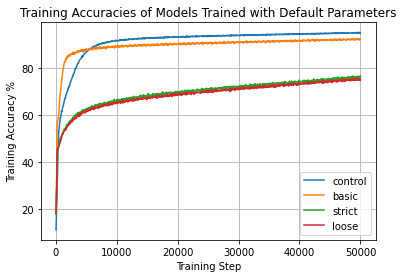

In [ ]:
plotTrainingAccuracies(
    evaluations = [defaultControlEval, defaultBasicEval, defaultStrictEval, defaultLooseEval],
    lineLabels =  ["control",          "basic",          "strict",          "loose"],
    title = "Training Accuracies of Models Trained with Default Parameters"
)

### Perfect prediction accuracies

How good were the models at fixing the bugs in the buggy AbstractMethods exactly as the developers did?

,model,accuracy
0,control,14.721508
1,basic,7.986290
2,strict,7.146530
3,loose,7.180805


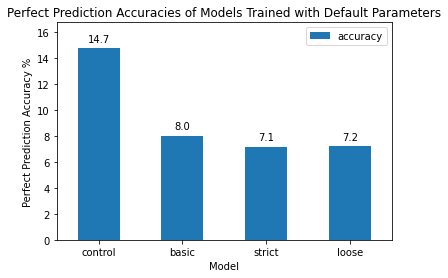

In [ ]:
plotPerfectPredictionAccuracies(
    evaluations = [defaultControlEval, defaultBasicEval, defaultStrictEval, defaultLooseEval],
    xLabels =     ["control",          "basic",          "strict",          "loose"],
    title = "Perfect Prediction Accuracies of Models Trained with Default Parameters"
)

### Failed prediction rates

How often did the models fail to output an `AbstractMethod`?

,model,rate
0,control,0.000000
1,basic,0.377035
2,strict,0.274207
3,loose,0.582691


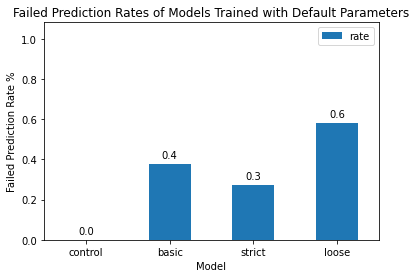

In [ ]:
plotFailedPredictionRates(
    evaluations = [defaultControlEval, defaultBasicEval, defaultStrictEval, defaultLooseEval],
    xLabels =     ["control",          "basic",          "strict",          "loose"],
    title = "Failed Prediction Rates of Models Trained with Default Parameters"
)

## Parameter group 1

In [ ]:
#collapse_output
group1ControlEval = HephaestusModelEvaluation(
    HephaestusModel(MODEL_GROUP1_CONTROL),
    testBuggyMethods,
    testFixedMethods,
    isControl = True
)

[2021-04-26 02:02:41,179 INFO] Translating shard 0.
[2021-04-26 02:03:19,869 INFO] PRED AVG SCORE: -0.0522, PRED PPL: 1.0535


In [ ]:
#collapse_output
group1BasicEval = HephaestusModelEvaluation(
    HephaestusModel(MODEL_GROUP1_BASIC),
    testBuggyMethods,
    testFixedMethods
)

[2021-04-26 02:03:24,200 INFO] Translating shard 0.
[2021-04-26 02:04:37,732 INFO] PRED AVG SCORE: -0.0668, PRED PPL: 1.0691


In [ ]:
#collapse_output
group1StrictEval = HephaestusModelEvaluation(
    HephaestusModel(MODEL_GROUP1_STRICT),
    testBuggyMethods,
    testFixedMethods
)

[2021-04-26 02:04:41,748 INFO] Translating shard 0.
[2021-04-26 02:05:04,218 INFO] PRED AVG SCORE: -0.4827, PRED PPL: 1.6204


In [ ]:
#collapse_output
group1LooseEval = HephaestusModelEvaluation(
    HephaestusModel(MODEL_GROUP1_LOOSE),
    testBuggyMethods,
    testFixedMethods
)

[2021-04-26 02:05:07,374 INFO] Translating shard 0.
[2021-04-26 02:05:25,155 INFO] PRED AVG SCORE: -0.4820, PRED PPL: 1.6193


### Training Accuracies

What were the training accuracies of the models?

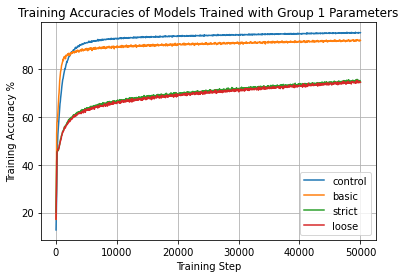

In [ ]:
plotTrainingAccuracies(
    evaluations = [group1ControlEval, group1BasicEval, group1StrictEval, group1LooseEval],
    lineLabels =  ["control",         "basic",         "strict",         "loose"],
    title = "Training Accuracies of Models Trained with Group 1 Parameters"
)

### Perfect prediction accuracies

How good were the models at fixing the bugs in the buggy AbstractMethods exactly as the developers did?

,model,accuracy
0,control,13.898886
1,basic,7.626392
2,strict,8.071979
3,loose,8.260497


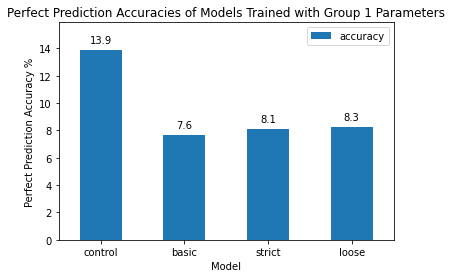

In [ ]:
plotPerfectPredictionAccuracies(
    evaluations = [group1ControlEval, group1BasicEval, group1StrictEval, group1LooseEval],
    xLabels =     ["control",         "basic",         "strict",         "loose"],
    title = "Perfect Prediction Accuracies of Models Trained with Group 1 Parameters"
)

### Failed prediction rates

How often did the models fail to output an `AbstractMethod`?

,model,rate
0,control,0.000000
1,basic,1.559554
2,strict,0.394173
3,loose,0.599829


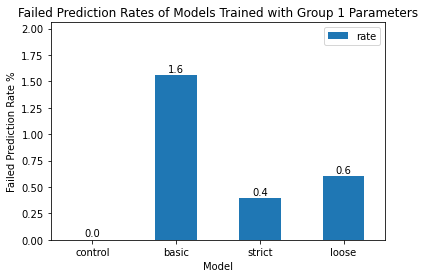

In [ ]:
plotFailedPredictionRates(
    evaluations = [group1ControlEval, group1BasicEval, group1StrictEval, group1LooseEval],
    xLabels =     ["control",         "basic",         "strict",         "loose"],
    title = "Failed Prediction Rates of Models Trained with Group 1 Parameters"
)

## Overall perfect prediction accuracies

,default params,group1 params
control,14.721508,13.898886
basic,7.986290,7.626392
strict,7.146530,8.071979
loose,7.180805,8.260497


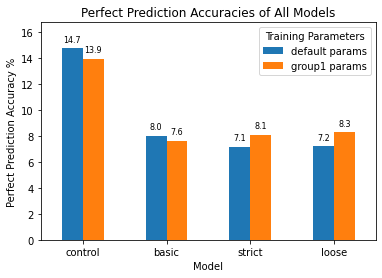

In [ ]:
plotAllPerfectPredictionAccuracies(
    evaluations = {
        "default params": [defaultControlEval, defaultBasicEval, defaultStrictEval, defaultLooseEval],
        "group1 params":  [group1ControlEval,  group1BasicEval,  group1StrictEval,  group1LooseEval]
    },
    xLabels =             ["control",          "basic",          "strict",          "loose"]
)

## Analysis

The perfect prediction accuracy is the most important metric here; it describes how well the model can actually function as a "bug fixer". The control model (trained only with AbstractMethods) performs significantly better than any of the models trained with EditOperations in this regard, no matter the models' training parameters. These results give evidence that training NMT models with EditOperations is not beneficial over the standard approach.